# 6. Evaluation

### 6.1.1 Gathering data

In [1]:
# Importing libraries
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as pt
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tqdm import tqdm
import torch
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error
import re
import matplotlib.pyplot as pt

In [2]:
# Setting up projectory directory

os.chdir(Path(os.path.realpath("")).resolve().parents[1])

In [3]:
# Importing modules that fetch data

from src.getter.load_application_and_opportunity import get_interim_data

# Gathering the data
ppdata = get_interim_data("preprocesseddata")

In [4]:
ppdata.columns

Index(['OpportunityId', 'ApplicationId', 'ExternalBriefDescription',
       'ExternalDescription', 'Title', 'JobCategoryName', 'IsRejected',
       'IsCandidateInternal', 'BehaviorCriteria', 'MotivationCriteria',
       'EducationCriteria', 'LicenseAndCertificationCriteria', 'SkillCriteria',
       'WorkExperiences', 'Educations', 'LicenseAndCertifications', 'Skills',
       'Motivations', 'Behaviors', 'StepId', 'StepName', 'Tag', 'StepGroup',
       'pass_first_step', 'ExternalBriefDescription__pp',
       'ExternalDescription__pp', 'Title__pp', 'JobCategoryName__pp',
       'BehaviorCriteria__pp', 'MotivationCriteria__pp',
       'EducationCriteria__pp', 'LicenseAndCertificationCriteria__pp',
       'SkillCriteria__pp', 'WorkExperiences__pp', 'Educations__pp',
       'LicenseAndCertifications__pp', 'Skills__pp', 'Motivations__pp',
       'Behaviors__pp', 'StepId__pp', 'StepName__pp', 'StepGroup__pp',
       'ExternalBriefDescription__w2vpp', 'ExternalDescription__w2vpp',
       'Titl

### 6.1.2 Setting column names into various classifiable lists for easy access

In [5]:
# Defining list of column names that contains the names of the columns, if they belong to the job or candidate

job_column = ['ExternalBriefDescription','ExternalDescription', 'Title', 
              'JobCategoryName']
uid_column = ['OpportunityId', 'ApplicationId']
can_column = [
    'IsCandidateInternal',
    'BehaviorCriteria', 
    'MotivationCriteria',
    'EducationCriteria', 
    'LicenseAndCertificationCriteria', 
    'SkillCriteria', 
    'WorkExperiences', 
    'Educations', 
    'LicenseAndCertifications', 
    'Skills', 
    'Motivations', 
    'Behaviors', 
    'StepName', 
    'StepGroup',
    'pass_first_step'
] # Column - StepId has been removed

sel_column = ['IsRejected']

# Defining list of columns based on the type of contents

str_column = [
    'ExternalBriefDescription', 
    'ExternalDescription', 
    'Title', 
    'JobCategoryName', 
    'BehaviorCriteria', 
    'MotivationCriteria', 
    'EducationCriteria', 
    'LicenseAndCertificationCriteria', 
    'SkillCriteria', 
    'WorkExperiences', 
    'Educations', 
    'LicenseAndCertifications', 
    'Skills', 
    'Motivations', 
    'Behaviors', 
    'StepId', 
    'StepName', 
    'StepGroup'
]
bool_column = ['IsCandidateInternal', 'pass_first_step']
float_column = ['Tag']

# Defining list of columns based on the models

model_names = ["w2v", "bert", "dbert"]

In [6]:
# Adding a new column count_opportunities, which count the occurence of application id for a given opportunity ID

ppdata = ppdata.merge(ppdata['OpportunityId'].value_counts(), on = 'OpportunityId')

(array([1055., 1558., 1926., ...,    0.,    0., 1176.]),
 array([1.00000000e+00, 1.97916667e+00, 2.95833333e+00, ...,
        1.17404167e+03, 1.17502083e+03, 1.17600000e+03]),
 <BarContainer object of 1200 artists>)

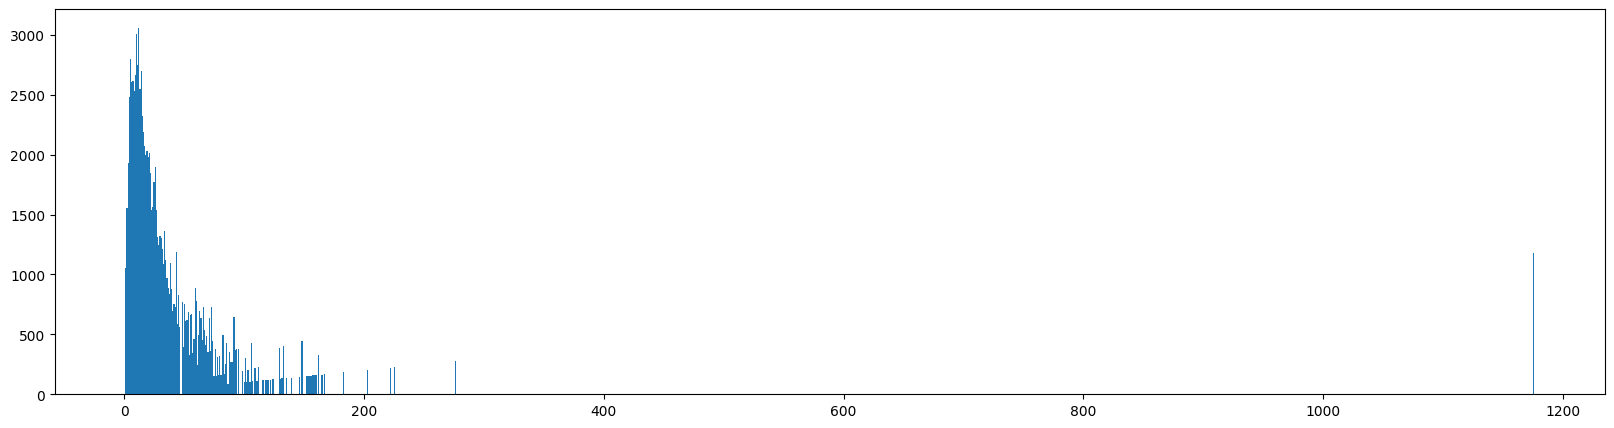

In [7]:
# Plotting the histogram for the count of frequency of number of applcants per opportunity

pt.figure(figsize = (20,5))

pt.hist(ppdata['count'], bins = 1200)

Maximum number of application put per person =  1176.0
Maximum number of applcations per candidate =  5139.0
Highest number of applcations recorded per candidate at 1000 bins =  6.875


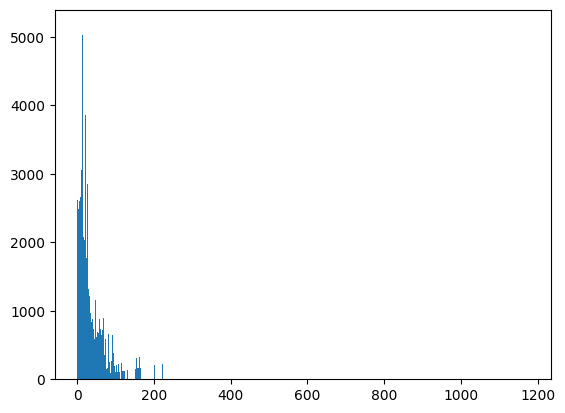

In [8]:
# Gathering the values
y, x, __ = pt.hist(ppdata['count'], bins = 1000)
print("Maximum number of application put per person = ", x.max())
print("Maximum number of applcations per candidate = " , y.max())
print("Highest number of applcations recorded per candidate at 1000 bins = ", x[np.argmax(y)])

About 5139 people had put an average of 6.875 applications i.e. about 6-7 application is where most number of candidates per job is the highest occurence. 


For the identification of the features, we first gather 10% of the data stratified by the OpportunityId. 

From the EDA, we realize that ther number of unique opportunity IDs are much lower than the application ID and also, that a given applicant has applied for 1 or more job. This implies the sample should be a representative of application-opportunity varied frequencies. Also, in dealing with a representative sample, we have observed that the rounding of the numbers creates selection issues so we address this by following the below 


In [9]:
# Stratification - as per strategy
to_stratify_ppdata = ppdata[ppdata['count'] < 10]

In [10]:
# We take 10 percent of the sample to begin with
total_sample = ppdata.shape[0]

# Calculating the sample size for calculations
sample_size = np.round(0.1 * total_sample)

# Creating a new DataFrame for selecting sample
ppdata_sampled = pd.DataFrame()

for opportunity_id, opportunity_groups in ppdata.groupby(by = ['OpportunityId']):
    if len(opportunity_groups) > 10:
        group_sample_count = int(np.round(0.1*len(opportunity_groups)))
        group_sampled_data = opportunity_groups.sample(n = group_sample_count, random_state = 2024)
        ppdata_sampled = pd.concat([ppdata_sampled, group_sampled_data], ignore_index = True)

diff_data = np.round(ppdata.shape[0]*0.1)-ppdata_sampled.shape[0]

# The below code ensures that we take care of the sample containing job opportunities with less than 10 applicants
# Creating a DataFrame that contains opportunity Ids with frequency lower than 10
to_stratify_ppdata = ppdata[ppdata['count'] <= 10]
__, stratified_10 = train_test_split(to_stratify_ppdata, test_size = diff_data/len(to_stratify_ppdata), random_state = 2024, stratify = to_stratify_ppdata['count'])

ppdata_sampled = pd.concat([ppdata_sampled, stratified_10], ignore_index = True)

Now we apply a series of steps that involves checking which of the feature is most important by removing one feature and then calculating the feature importance and then compare it with the original cosine similarity values.

We start by calculating the cosine similarity values for the entire set. 

In [11]:
ppdata_sampled.columns

Index(['OpportunityId', 'ApplicationId', 'ExternalBriefDescription',
       'ExternalDescription', 'Title', 'JobCategoryName', 'IsRejected',
       'IsCandidateInternal', 'BehaviorCriteria', 'MotivationCriteria',
       'EducationCriteria', 'LicenseAndCertificationCriteria', 'SkillCriteria',
       'WorkExperiences', 'Educations', 'LicenseAndCertifications', 'Skills',
       'Motivations', 'Behaviors', 'StepId', 'StepName', 'Tag', 'StepGroup',
       'pass_first_step', 'ExternalBriefDescription__pp',
       'ExternalDescription__pp', 'Title__pp', 'JobCategoryName__pp',
       'BehaviorCriteria__pp', 'MotivationCriteria__pp',
       'EducationCriteria__pp', 'LicenseAndCertificationCriteria__pp',
       'SkillCriteria__pp', 'WorkExperiences__pp', 'Educations__pp',
       'LicenseAndCertifications__pp', 'Skills__pp', 'Motivations__pp',
       'Behaviors__pp', 'StepId__pp', 'StepName__pp', 'StepGroup__pp',
       'ExternalBriefDescription__w2vpp', 'ExternalDescription__w2vpp',
       'Titl

In [12]:
# Importing the featurization modules from src 
from src.featurization.featurization import *

# Importing the model training modules from src
from src.model_training.model_training import *

As previously explained: The padding aspect in encode_and_pad_boolean_columns and pad_float_columns functions were created keeping the vstacking in mind. However, we use the same fucntions for hstacking to maintain uniformity. Though it adds unwanted dimensions, the result is likely not going to be affected because we pad with the vectors with zero. 

We calculate the cosine_similarities for the enitre dataset: ppdata_sampled and then later we remove one feature out and calculate the rms with the cosine similairty of the entire ppdata_sampled

In [13]:
# Creating the necessary functions that input the requireed lists and data to calculate the cosine similarity 

def generate_cosine_data(ppdata_sampled, model_names, uid_column, can_column, job_column, str_column, bool_column, float_column, vstack = False):
    """
    Generate cosine similarity data for different model types.

    Args:
        model_names (list): List of model names.
        uid_column (str): Column name of uniqaue identifiers.
        ppdata_sampled (DataFrame): Sampled DataFrame containing the data.
        can_column (list): List of column names related to candidates.
        job_column (list): List of column names related to jobs.
        str_column (list): List of column names with string data type.
        bool_column (list): List of column names with boolean data type.

    Returns:
        dict: A dictionary containing cosine similarity data for each model type.
    """
    # Checking if the required functions have been downloaded
    required_functions = ['w2vbased_embedder', 'modelbased_embedder', 'reduce_dimensionality', 'pairwise_cosine']
    for func_name in required_functions:
        if func_name not in globals():
            raise ImportError(f"Function '{func_name}' is not imported. Please import all necessary functions.")
    

    cosine_data_all = {}
    feat_dict_all = {}

    for model_type in model_names:
        # data = ppdata-sampled
        feat_dict_all = {}

        for u_id in uid_column:
            columns = can_column if u_id == "ApplicationId" else job_column
            str_col = [x for x in columns if x in str_column]
            bool_col = [x for x in columns if x in bool_column]
            float_col = [x for x in columns if x in float_column]
            
            # Applying model appropriate featurization - 3
            if model_type == "w2v":

                #Applying w2vbased_embedder on 
                dict_hstack, dict_vstack = w2vbased_embedder(ppdata_sampled, u_id, str_col, bool_col, float_col)


                #introduce a dict that takes in hstack and vstack values
                feat_dict_all[model_type + "_" + u_id + "_hstack_vectors"] = dict_hstack
                if vstack:
                    feat_dict_all[model_type + "_" + u_id + "_vstack_vectors"] = dict_vstack

            else:
                hugging_face_model_name = "bert-base-uncased" if model_type == "bert" else "distilbert-base-uncased"

                # Applying modelbased_embedder
                dict_hstack, dict_vstack = modelbased_embedder(ppdata_sampled, u_id, str_col, bool_col, float_col, hugging_face_model_name)

                #introduce a dict that takes in hstack and vstack values
                feat_dict_all[model_type + "_" + u_id + "_hstack_vectors"] = dict_hstack
                if vstack:
                    feat_dict_all[model_type + "_" + u_id + "_vstack_vectors"] = dict_vstack

        # Applying dimensionality reduction - 4a.2.1
        opp_pca_hstack, app_pca_hstack = reduce_dimensionality(ppdata_sampled[uid_column], "OpportunityId", "ApplicationId", 
                                                               feat_dict_all[model_type + "_" + "OpportunityId" + "_hstack_vectors"], 
                                                               feat_dict_all[model_type + "_" + "ApplicationId" + "_hstack_vectors"])
        if vstack:
            opp_pca_vstack, app_pca_vstack = reduce_dimensionality(ppdata_sampled[uid_column], "OpportunityId", "ApplicationId", 
                                                                   feat_dict_all[model_type + "_" + "OpportunityId" + "_vstack_vectors"], 
                                                                   feat_dict_all[model_type + "_" + "ApplicationId" + "_vstack_vectors"])
        
        # Cosine-similarity pairwise
        cosine_sim_opp_app_hstack = pairwise_cosine(ppdata_sampled, "OpportunityId", "ApplicationId", opp_pca_hstack, app_pca_hstack)
        if vstack:
            cosine_sim_opp_app_vstack = pairwise_cosine(ppdata_sampled, "OpportunityId", "ApplicationId", opp_pca_vstack, app_pca_vstack)
        
        # Saving data in dictionary    
        cosine_data_all['cosine_hstack_' + model_type] = cosine_sim_opp_app_hstack
        if vstack:
            cosine_data_all['cosine_vstack_' + model_type] = cosine_sim_opp_app_vstack

    return cosine_data_all


In [14]:
# Applying Generate cosine_data to the data
cosine_data_all = generate_cosine_data(ppdata_sampled, model_names, uid_column, can_column, job_column, str_column, bool_column, float_column, vstack = True)

Processing rows: 100%|██████████| 11027/11027 [1:07:10<00:00,  2.74it/s]


In [15]:
# Creating functions that remove features from list and the data

def remove_features_from_list(feature_list, column_list, suffixes = []):
    
    '''
    Removes features named in the feature_list and their corresponding 
    suffixed features from the column list as an iteration and returns a list 
    of lists without columns

    Args:
        feature_list (list): List of features to be removed iteratively
        column_list (list): List of columns names from which the features need
        to be removed

    Returns:
        list: List of lists containing the modified columns names, i.e. the 
        column_list minus the namne(iteratively) of the feature and features 
        if occuring. 
    '''
    modified_lists = []

    for feature in feature_list:

        modified_list = column_list.copy()

        if suffixes:
            drop_labels = [feature] + [(feature + x) for x in suffixes if (feature + x) in column_list] 
            
            for i in drop_labels:
                try:
                    modified_list.remove(i)
                except: ValueError
            
            modified_lists.append(modified_list)
        
        else: 
            try:
                modified_list.remove(feature)
            except: ValueError

            modified_lists.append(modified_list)

    return modified_lists


def remove_features_from_data(feature_list, dataframe, suffixes = []):
    ''''
    Remove specified features and their corresponding suffixed features from the DataFrame.

    Args:
        feature_list (list): List of features to be removed.
        dataframe (pandas.DataFrame): DataFrame containing the data.
        suffixes (list, optional): List of suffixes for the features. Default is an empty list.

    Returns:
        list: List of modified DataFrames with specified features removed.
    '''

    modified_lists = []
    
    for feature in feature_list:

        modified_data = dataframe.copy()
        
        if suffixes:
            drop_labels = [feature] + [(feature + x) for x in suffixes if (feature + x) in dataframe.columns] 

            for i in drop_labels:
                try:
                    modified_data.drop(labels = drop_labels, axis = 1, inplace = True)
                except: KeyError

            modified_lists.append(modified_data)
                
        else:
            try:
                modified_data.drop(feature, axis = 1, inplace = True)
            except: KeyError
            
            modified_lists.append(modified_data)

    return modified_lists

In [16]:
# Creating necessary lists for calculating RMS
# can_column, job_column, str_column, bool_column, float_column
features = job_column + can_column
job_column__ = remove_features_from_list(features, job_column)
can_column__ = remove_features_from_list(features, can_column)
str_column__ = remove_features_from_list(features, str_column)
bool_column__ = remove_features_from_list(features, bool_column)
float_column__ = remove_features_from_list(features, float_column)

# Creating necesary list of data for calculation RMS
# data = ppdata_sampled
ppdata_sampled__ = remove_features_from_data(features, ppdata_sampled, ['__pp', '__w2vpp', '__trnsfrmrpp'])

In [17]:
# Calculating the cosine values and evaluating the RMS to get top important features
rms_w2v, rms_bert, rms_dbert = {}, {}, {}
vstack = True
for i, feature in enumerate(features):
    cosine_data__ = generate_cosine_data(ppdata_sampled__[i], model_names,
                                          uid_column, can_column__[i], 
                                          job_column__[i], str_column__[i], 
                                          bool_column__[i], float_column__[i], 
                                          vstack = vstack)
    
    for model_type in model_names:
        # Preparing data for RMS calculation - model_type wise
        analysis_data_hstack__ = cosine_data_all['cosine_hstack_' + model_type].merge(cosine_data__['cosine_hstack_' + model_type], left_on = uid_column, right_on = uid_column, suffixes = ('_all', '_' + model_type) )
        if vstack:
            analysis_data_vstack__ = cosine_data_all['cosine_vstack_' + model_type].merge(cosine_data__['cosine_vstack_' + model_type], left_on = uid_column, right_on = uid_column, suffixes = ('_all', '_' + model_type))
        
        # Calculating the RMS
        rms_value_hstack = mean_squared_error(analysis_data_hstack__['row_similarity' + '_all'], analysis_data_hstack__['row_similarity' + '_' + model_type])
        if vstack:
            rms_value_vstack = mean_squared_error(analysis_data_vstack__['row_similarity' + '_all'], analysis_data_vstack__['row_similarity' + '_' + model_type])

        if model_type == 'w2v':
            rms_w2v['rms_' + model_type + '_' + feature + '_hstack'] = rms_value_hstack
            if vstack:
                rms_w2v['rms_' + model_type + '_' + feature + '_vstack'] = rms_value_vstack

        elif model_type == 'bert':
            rms_bert['rms_' + model_type + '_' + feature + '_hstack'] = rms_value_hstack
            if vstack:
                rms_bert['rms_' + model_type + '_' + feature + '_vstack'] = rms_value_vstack

        else:
            rms_dbert['rms_' + model_type + '_' + feature + '_hstack'] = rms_value_hstack
            if vstack:
                rms_dbert['rms_' + model_type + '_' + feature + '_vstack'] = rms_value_vstack
        

Processing rows:  57%|█████▋    | 6284/11027 [40:33<22:36,  3.50it/s]  

In [ ]:
rms_w2v

{'rms_w2v_ExternalBriefDescription_hstack': 0.0008730467513300764,
 'rms_w2v_ExternalBriefDescription_vstack': 0.0009845624893119053,
 'rms_w2v_ExternalDescription_hstack': 0.00048432187568887494,
 'rms_w2v_ExternalDescription_vstack': 0.001268628088134825,
 'rms_w2v_Title_hstack': 0.00033713423336818394,
 'rms_w2v_Title_vstack': 0.0008646296322039295,
 'rms_w2v_JobCategoryName_hstack': 0.00040054587007049724,
 'rms_w2v_JobCategoryName_vstack': 0.0004947900173155675,
 'rms_w2v_IsCandidateInternal_hstack': 0.0004144510631966559,
 'rms_w2v_IsCandidateInternal_vstack': 0.0008437806133595808,
 'rms_w2v_BehaviorCriteria_hstack': 0.001219827019928241,
 'rms_w2v_BehaviorCriteria_vstack': 0.0010209476464237092,
 'rms_w2v_MotivationCriteria_hstack': 0.0006045658941733595,
 'rms_w2v_MotivationCriteria_vstack': 0.0007395457369948258,
 'rms_w2v_EducationCriteria_hstack': 0.0005681933647667489,
 'rms_w2v_EducationCriteria_vstack': 0.0007958966579920661,
 'rms_w2v_LicenseAndCertificationCriteria_hst

In [ ]:
# Splitting into multiple dictionaries: 
#w2v
rms_w2v_hstack, rms_w2v_vstack = {}, {}
for k, v in rms_w2v.items():
    if re.match(r'\w+_hstack', k):
        rms_w2v_hstack[k] = v
    else:
        rms_w2v_vstack[k] = v

#bert
rms_bert_hstack, rms_bert_vstack = {}, {}
for k, v in rms_bert.items():
    if re.match(r'\w+_hstack', k):
        rms_bert_hstack[k] = v
    else:
        rms_bert_vstack[k] = v

#dbert
rms_dbert_hstack, rms_dbert_vstack = {}, {}
for k, v in rms_dbert.items():
    if re.match(r'\w+_hstack', k):
        rms_dbert_hstack[k] = v
    else:
        rms_dbert_vstack[k] = v

In [ ]:
# Saving the data - Gathering necessary libraries

from src.getter.save_application_and_opportunity import save_processed_data

# Saving the data 
save_processed_data(rms_w2v, "rms_w2v")
save_processed_data(rms_bert, "rms_bert")
save_processed_data(rms_dbert, "rms_dbert")


In [ ]:
def top_n_features(rms_dict, n = 19):

    '''
    Returns top n features with highest difference in rms score
    '''
    return dict(sorted(rms_dict.items(), key = lambda x : x[1], reverse = True)[:n])


In [ ]:
# Gathering top n features for various n
for model_name in model_names:
    for n in [3,5,7,10,15,19]:
        if model_name == 'w2v':
                print('Top {} features for model - {}_hstack: '.format(n, model_name), top_n_features(rms_w2v_hstack, n), '\n', '='*50)
        elif model_name == 'bert':
            print('Top {} features for model - {}_hstack: '.format(n, model_name), top_n_features(rms_bert_hstack, n), '\n', '='*50)
        else :
            print('Top {} features for model - {}_hstack: '.format(n, model_name), top_n_features(rms_dbert_hstack, n), '\n', '='*50)
    print('\n\n')

for model_name in model_names:
    for n in [3,5,7,10,15,19]:
        if model_name == 'w2v':
                print('Top {} features for model - {}_vstack: '.format(n, model_name), top_n_features(rms_w2v_vstack, n), '\n', '='*50)
        elif model_name == 'bert':
            print('Top {} features for model - {}_vstack: '.format(n, model_name), top_n_features(rms_bert_vstack, n), '\n', '='*50)
        else :
            print('Top {} features for model - {}_vstack: '.format(n, model_name), top_n_features(rms_dbert_vstack, n), '\n', '='*50)
    print('\n\n')



Top 3 features for model - w2v_hstack:  {'rms_w2v_BehaviorCriteria_hstack': 0.001219827019928241, 'rms_w2v_Motivations_hstack': 0.001131403914962925, 'rms_w2v_SkillCriteria_hstack': 0.000997558318471026} 
Top 5 features for model - w2v_hstack:  {'rms_w2v_BehaviorCriteria_hstack': 0.001219827019928241, 'rms_w2v_Motivations_hstack': 0.001131403914962925, 'rms_w2v_SkillCriteria_hstack': 0.000997558318471026, 'rms_w2v_ExternalBriefDescription_hstack': 0.0008730467513300764, 'rms_w2v_Behaviors_hstack': 0.0008700382002662175} 
Top 7 features for model - w2v_hstack:  {'rms_w2v_BehaviorCriteria_hstack': 0.001219827019928241, 'rms_w2v_Motivations_hstack': 0.001131403914962925, 'rms_w2v_SkillCriteria_hstack': 0.000997558318471026, 'rms_w2v_ExternalBriefDescription_hstack': 0.0008730467513300764, 'rms_w2v_Behaviors_hstack': 0.0008700382002662175, 'rms_w2v_MotivationCriteria_hstack': 0.0006045658941733595, 'rms_w2v_pass_first_step_hstack': 0.0005716973084508453} 
Top 10 features for model - w2v_hs

In [ ]:
'''# Checking which of the rms values is greatest feature wise:

for i in range(len(rms_w2v)):
    w2v_key = list(rms_w2v.keys())[i]
    bert_key = list(rms_bert.keys())[i]
    dbert_key = list(rms_dbert.keys())[i]

    if rms_w2v[w2v_key] > rms_bert[bert_key] and rms_w2v[w2v_key] > rms_dbert[dbert_key]:
        print(f"(w2v_key): rms_w2v is the largest")
    elif rms_bert[bert_key] > rms_w2v[w2v_key] and rms_bert[bert_key] > rms_dbert[dbert_key]:
        print(f"(bert_key): rms_bert is the largest")
    else:
        print(f"(dbert_key); rms_dbert is the largest")'''

(w2v_key): rms_w2v is the largest
(w2v_key): rms_w2v is the largest
(w2v_key): rms_w2v is the largest
(w2v_key): rms_w2v is the largest
(w2v_key): rms_w2v is the largest
(w2v_key): rms_w2v is the largest
(w2v_key): rms_w2v is the largest
(w2v_key): rms_w2v is the largest
(w2v_key): rms_w2v is the largest
(w2v_key): rms_w2v is the largest
(w2v_key): rms_w2v is the largest
(w2v_key): rms_w2v is the largest
(w2v_key): rms_w2v is the largest
(bert_key): rms_bert is the largest
(w2v_key): rms_w2v is the largest
(w2v_key): rms_w2v is the largest
(bert_key): rms_bert is the largest
(w2v_key): rms_w2v is the largest
(w2v_key): rms_w2v is the largest
(w2v_key): rms_w2v is the largest
(w2v_key): rms_w2v is the largest
(w2v_key): rms_w2v is the largest
(w2v_key): rms_w2v is the largest
(w2v_key): rms_w2v is the largest
(w2v_key): rms_w2v is the largest
(w2v_key): rms_w2v is the largest
(w2v_key): rms_w2v is the largest
(w2v_key): rms_w2v is the largest
(w2v_key): rms_w2v is the largest
(w2v_key):

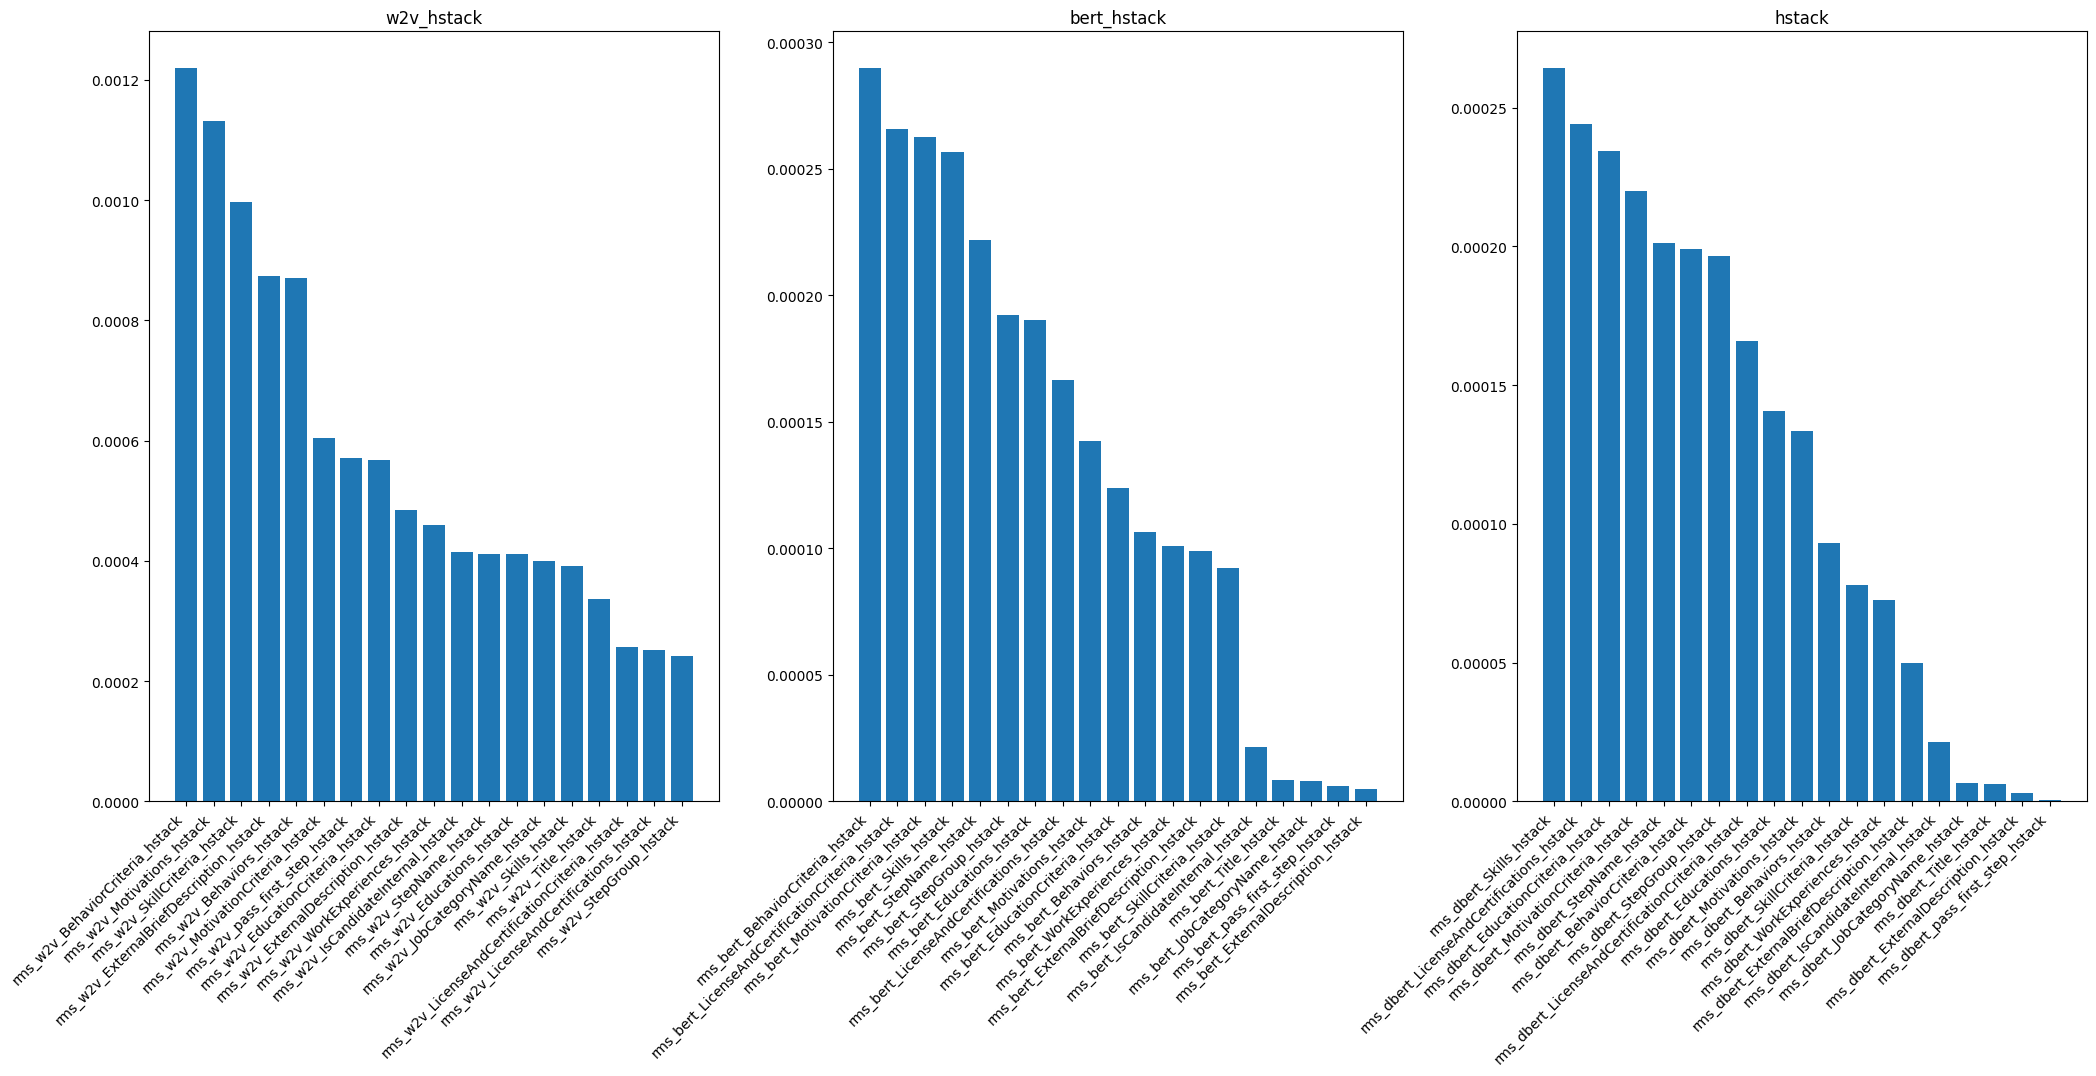

In [ ]:
# Plotting graphs - hstack

fig, (ax1, ax2, ax3) = pt.subplots(1, 3, figsize = (25,10))


ax1.bar(list(top_n_features(rms_w2v_hstack).keys()), list(top_n_features(rms_w2v_hstack).values()))
ax1.set_title("w2v_hstack")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 45, ha='right')

ax2.bar(list(top_n_features(rms_bert_hstack).keys()), list(top_n_features(rms_bert_hstack).values()))
ax2.set_title("bert_hstack")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 45, ha='right')

ax3.bar(list(top_n_features(rms_dbert_hstack).keys()), list(top_n_features(rms_dbert_hstack).values()))
ax3.set_title("dbert_hstack")
ax3.set_xticklabels(ax3.get_xticklabels(), rotation = 45, ha='right')

pt.title("hstack")
pt.show()

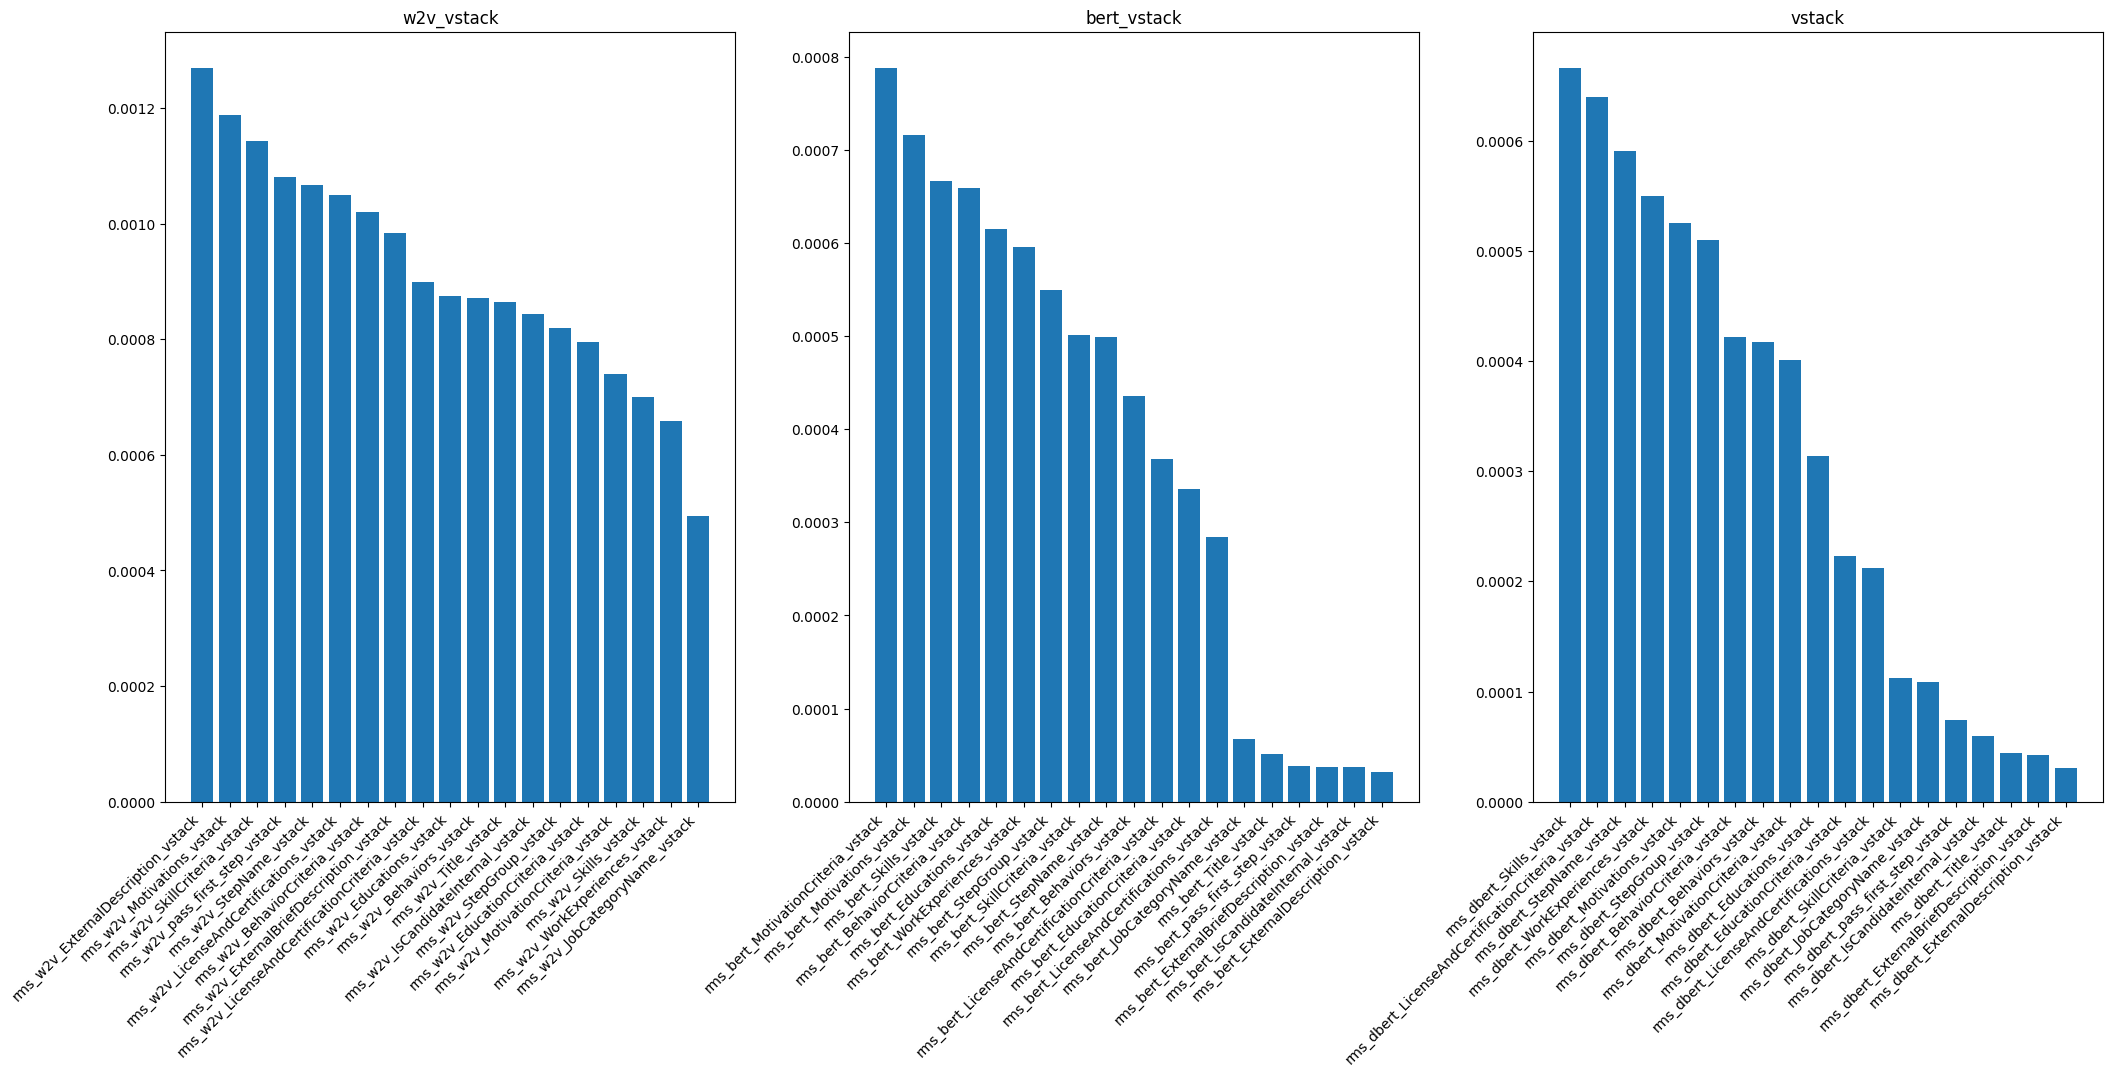

In [ ]:
# Plotting graphs - vstack

fig, (ax1, ax2, ax3) = pt.subplots(1, 3, figsize = (25,10))


ax1.bar(list(top_n_features(rms_w2v_vstack).keys()), list(top_n_features(rms_w2v_vstack).values()))
ax1.set_title("w2v_vstack")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation = 45, ha='right')

ax2.bar(list(top_n_features(rms_bert_vstack).keys()), list(top_n_features(rms_bert_vstack).values()))
ax2.set_title("bert_vstack")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 45, ha='right')

ax3.bar(list(top_n_features(rms_dbert_vstack).keys()), list(top_n_features(rms_dbert_vstack).values()))
ax3.set_title("dbert_vstack")
ax3.set_xticklabels(ax3.get_xticklabels(), rotation = 45, ha='right')

pt.title("vstack")
pt.show()